In [72]:
# Standard library imports
import os
import re
from dotenv import load_dotenv
import dotenv
load_dotenv()  # .env 파일 로드
import operator
import matplotlib.pyplot as plt
from uuid import uuid4
from typing import TypedDict, List, Literal, Annotated, Optional

# Local imports
from utils.get_inputs import InputHandler_file_only
from utils.with_postgre import PostgresDB
from utils.with_pgvector import pgvector
from utils.with_langs import MODEL, draw_graph, stream_structured_output

# Third party imports
import pandas as pd
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, MessagesState, END
from langgraph.types import Command
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage
from langgraph.checkpoint.memory import MemorySaver

In [73]:
## 테스트용 질문들
user_input_common = "안녕"
user_input_query = """가입일자가 '2019-12-05'인 고객의 고객ID, 계좌번호, 가입금액을 조회하는 쿼리 작성해줘."""
user_input_querychart = """가입일자가 '2019-12-05'인 고객의 고객ID, 계좌번호, 가입금액을 조회하고 차트로 그려줘"""
user_input_queryinsight = """가입일자가 '2019-12-05'인 고객의 고객ID, 계좌번호, 가입금액을 조회하고 비즈니스 인사이트를 알려줘"""
user_input_query_chart_insight = """가입일자가 '2019-12-05'인 고객의 고객ID, 계좌번호, 가입금액을 조회하고 차트로 그려줘. 비즈니스 인사이트도 알려줘"""
messages = [
    HumanMessage(content="안녕하세요"),
    AIMessage(content="안녕하세요 반가워요"),
    HumanMessage(content="오늘 날씨 어때요?")
]

query = """SELECT 
    고객ID, 
    계좌번호, 
    가입금액
FROM 
    biz.PRODUCT_HISTORY
WHERE 
    가입일자 = '2019-12-05';  -- 가입일자가 2019-12-05인 고객 필터링"""

query_result = [('C009675', '4237-971-70549884', 390000),
 ('C012869', '4513-703-55516178', 5000000),
 ('C015139', '4295-649-82589758', 310000),
 ('C015946', '2282-680-89088136', 40000),
 ('C017437', '8765-415-43075451', 5000000),
 ('C018900', '4957-124-69145766', 470000),
 ('C023751', '2008-147-25173675', 120000),
 ('C027483', '9275-030-68395820', 390000),
 ('C033382', '4315-033-00073694', 380000),
 ('C037114', '5571-808-82863935', 1000000),
 ('C047819', '1686-174-51368059', 5000000),
 ('C051082', '8970-286-30491002', 50000),
 ('C054494', '4940-076-84863552', 230000),
 ('C063499', '3342-519-38014684', 440000),
 ('C067720', '2202-756-82557749', 100000000)]

In [74]:
######## 기본 세팅 ########
###  사용자 직접 입력   ####################
schema_name = "biz" # DB 스키마 이름
num_db_return = 20  # 쿼리 실행 결과 반환 행 수
img_folder = 'img/' # 차트빌더에서 생성한 이미지 저장 폴더
###########################################

### 제너럴 세팅
dotenv.load_dotenv(override=True)
gmodel = MODEL
# fmodel = MODEL_FINETUNED
fmodel = os.getenv("OPENAI_FINETUNED_MODEL")
llm = ChatOpenAI(model=gmodel, temperature=0)
db = PostgresDB()
vs = pgvector() # RAG
input_handler = InputHandler_file_only()
retriever = vs.as_retriever(
    search_type = 'mmr',      # Maximal Marginal Relevance
    search_kwargs = {
        'k'           : 10,   # Number of documents to retrieve
        'fetch_k'     : 100,  # Number of documents to consider for MMR
        'lambda_mult' : 0.6,  # Diversity adjustment (0.0: similarity-only, 1.0: diversity-only)
    }
)

# 프롬프트, DB 정보 읽어오기
core_prompt_supervisor = input_handler.read_file('prompt_supervisor.txt')
core_prompt_sqlbuilder = input_handler.read_file('prompt_sqlbuilder.txt').format(schema_name=schema_name)
core_prompt_chartbuilder = input_handler.read_file('prompt_chartbuilder.txt')
core_prompt_insightbuilder = input_handler.read_file('prompt_insightbuilder.txt')
table_ddl = input_handler.read_file('DB Schema.txt')

[LOG] params = {'dbname': 'postgres', 'user': 'postgres', 'password': 'rnjstkddn1!', 'host': 'localhost', 'port': '5432', 'options': '-c statement_timeout=20000'}
[LOG] attempts = [{'dbname': 'postgres', 'user': 'postgres', 'password': 'rnjstkddn1!', 'host': 'localhost', 'port': '5432', 'options': '-c statement_timeout=20000', 'hostaddr': '::1'}, {'dbname': 'postgres', 'user': 'postgres', 'password': 'rnjstkddn1!', 'host': 'localhost', 'port': '5432', 'options': '-c statement_timeout=20000', 'hostaddr': '127.0.0.1'}]
[LOG] conninfo = dbname=postgres user=postgres password=rnjstkddn1! host=localhost port=5432 options='-c statement_timeout=20000' hostaddr=::1
[LOG] gen = <generator object BaseConnection._connect_gen at 0x000001A6CF5086D0>
[LOG] params = {'host': 'localhost', 'dbname': 'postgres', 'user': 'pinetree', 'password': 'pinetree123', 'port': 1989}
[LOG] attempts = [{'host': 'localhost', 'dbname': 'postgres', 'user': 'pinetree', 'password': 'pinetree123', 'port': 1989, 'hostaddr'

In [75]:
###########################################
########  프롬프트 세팅
# Supervisor
prompt_supervisor = ChatPromptTemplate(
    [
        (
            "system", 
            core_prompt_supervisor
        ),
        MessagesPlaceholder("messages")
    ]
)


# SQL Builder
base_prompt_sql_builder = "{prompt_sqlbuilder}\n\n" + \
                    "**Database Information(DDL)**\n{table_ddl}"

prompt_sql_builder = ChatPromptTemplate(
    [
        ("system", base_prompt_sql_builder),
        MessagesPlaceholder("messages")
    ],
    input_variables=["messages"],
    partial_variables={"prompt_sqlbuilder": core_prompt_sqlbuilder, "table_ddl": table_ddl}
)


# SQL Rebuilder
base_prompt_sql_rebuilder = """Correct the query based on the error message.

SQL Query:
{sql_query}

Error Message:
{error_message}
"""

prompt_sql_rebuilder = ChatPromptTemplate(
    [
        ("system", base_prompt_sql_rebuilder)
    ],
    input_variables=["sql_query", "error_message"],
)


# Chart Builder
prompt_chart_builder = ChatPromptTemplate(
    [
        ("system", core_prompt_chartbuilder),
        MessagesPlaceholder("messages")
    ],
    input_variables=["messages"],
)


# Insight Builder
prompt_insight_builder = ChatPromptTemplate(
    [
        ("system", core_prompt_insightbuilder),
        MessagesPlaceholder("messages")
    ],
    input_variables=["messages"],
)

In [76]:
######## 슈퍼바이저
# 공용 State
class State(MessagesState):
    ...


# supervisor
agents = ['SQL_Builder', 'Chart_Builder', 'Insight_Builder', 'Replier']

class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""
    next: Literal[*agents, '__end__']

def supervisor(state: State) -> Command[Literal[*agents, '__end__']]:
    """Routes user requests to appropriate specialized agents based on input analysis."""
    chain = prompt_supervisor | llm.with_structured_output(Router)
    ret = chain.invoke({"messages": state['messages']})

    return Command(goto=ret['next'])

def replier(state: State) -> Command[Literal['__end__']]:
    """Answer to user's question which is not related to sql, chart, insight."""
    prompt = ChatPromptTemplate.from_messages([
        ("system", "사용자 질문에 대한 대답이 메세지 히스토리에 이미 들어있으면 'end'를 반환, 그렇지 않으면 질문에 대답해라")
    ])
    chain = prompt | llm
    ret = chain.invoke({"messages": state["messages"]})

    if ret.content == 'end':    
        return Command(goto=END)
    else:
        return Command(
            update={"messages": [llm.invoke(state["messages"])]},
            goto=END
        )

### 슈퍼바이저 정상 작동 테스트스트
# def dummy_sql_builder(state: State):
#     return {"messages": [AIMessage(content="dummy_sql_builder 통과함")]}

# def dummy_chart_builder(state: State):
#     return {"messages": [AIMessage(content="dummy_chart_builder 통과함")]}

# def dummy_insight_builder(state: State):
#     return {"messages": [AIMessage(content="dummy_insight_builder 통과함")]}

# def dummy_chatbot(state: State):
#     return {"messages": [AIMessage(content="dummy_chatbot 통과함")]}

# tmp_workflow = StateGraph(State)
# tmp_workflow.add_node("Supervisor", supervisor)
# tmp_workflow.add_node("SQL_Builder", dummy_sql_builder)
# tmp_workflow.add_node("Chart_Builder", dummy_chart_builder)
# tmp_workflow.add_node("Insight_Builder", dummy_insight_builder)
# tmp_workflow.add_node("Chatbot", dummy_chatbot)

# tmp_workflow.set_entry_point("Supervisor")
# tmp_app = tmp_workflow.compile()

# draw_graph(tmp_app)

In [77]:
######## SQL 빌더
# rag
def replace_strings_once(sentence, replacements):
    """단어를 동시에 한 번만 치환"""

    pattern = re.compile("|".join(re.escape(key) for key in replacements.keys()))
    
    def replace_match(match):
        return replacements[match.group(0)]
    
    return pattern.sub(replace_match, sentence)

def rag_node(state: State):
    """우선은 유의어 사전에서 유사도 검사 후 사용자 질문 수정만 구현"""
    user_input = state["messages"][-1].content
    retrieved = retriever.invoke(user_input)
    replacements = {}
    for doc in retrieved:
        original_term, standard_term = doc.page_content.split(':')
        replacements[original_term] = standard_term
    
    replaced = replace_strings_once(user_input, replacements)

    state['messages'][-1].content = replaced
    return {}

class Query(TypedDict):
    query: str
    
def sql_builder(state: State) -> Command[Literal['sql_rebuilder', '__end__']]:
    """Generate a SQL query based on the system prompt and the user's question."""
    chain = prompt_sql_builder | llm.with_structured_output(Query)
    query = chain.invoke(state["messages"])['query'] # 쿼리 생성 및 추출
    print(f'query', query)
    flag, ret = db.run(query) # 쿼리 실행

    if flag:
        headers = [col.name for col in db.cursor.description]
        df = pd.DataFrame(ret, columns=headers).to_markdown()
        return Command(
            update={
                "messages": [
                    HumanMessage(content=f"**쿼리**\n```sql\n{query}```\n**쿼리 실행 결과**\n{df}")
                ]
            },
            goto="__end__"
        )
    else:
        return Command(
            update={
                "messages": [
                    HumanMessage(content=f"**쿼리**\n```sql\n{query}```\n**쿼리 실행 결과**\n{ret}")
                ]
            },
            goto="sql_rebuilder"
        )


def sql_rebuilder(state: State) -> Command[Literal['sql_rebuilder', '__end__']]:
    last_message = state["messages"][-1].content
    query = last_message.split('```sql\n')[1].split('```')[0] # 쿼리 추출
    error_message = last_message.split('**쿼리 실행 결과**\n')[1] # 오류 메세지 추출

    chain = prompt_sql_rebuilder | llm.with_structured_output(Query)
    new_query = chain.invoke({"sql_query": query, "error_message": error_message})
    flag, ret = db.run(new_query)

    if flag:
        headers = [col.name for col in db.cursor.description]
        df = pd.DataFrame(ret, columns=headers).to_markdown()
        return Command(
            update={
                "messages": [
                    HumanMessage(content=f"**쿼리**\n```sql\n{new_query}```\n**쿼리 실행 결과**\n{df}")
                ]
            },
            goto="__end__"
        )
    else:
        return Command(
            update={
                "messages": [
                    HumanMessage(content=f"**쿼리**\n```sql\n{new_query}```\n**쿼리 실행 결과**\n{ret}")
                ]
            },
            goto="sql_rebuilder"
        )


workflow_subgraph_sqlbuilder = StateGraph(State)
workflow_subgraph_sqlbuilder.add_node("rag", rag_node)
workflow_subgraph_sqlbuilder.add_node("sql_builder", sql_builder)
workflow_subgraph_sqlbuilder.add_node("sql_rebuilder", sql_rebuilder)

workflow_subgraph_sqlbuilder.set_entry_point("rag")
workflow_subgraph_sqlbuilder.add_edge("rag", "sql_builder")

subgraph_sqlbuilder = workflow_subgraph_sqlbuilder.compile()

# draw_graph(subgraph_sqlbuilder)

In [78]:
######## 차트 빌더
def save_code_result_as_image(code: str):
    """Save the result of the code as an image."""
    # Generate random filename
    filename = f'plot_{uuid4()}.png'
    
    os.makedirs('img', exist_ok=True)
    # plt.show() 앞에 이미지 저장 코드 추가
    modified_code = code.split("plt.show()")[0] + f"\nplt.savefig('{img_folder}/{filename}')\nplt.show()"
    exec(modified_code)  # Execute the modified code
    plt.close()  # Close the figure to free memory
    return filename

def chart_builder(state: State):
    """Generate a chart based on the user's question and the query result."""
    chain = prompt_chart_builder | llm.with_structured_output(save_code_result_as_image)
    chart_code = chain.invoke({"messages": state["messages"]})['code']
    filename = save_code_result_as_image(chart_code)
    return {"messages": HumanMessage(content=f"**Code**\n{chart_code}\n**차트 이미지 파일명**\n{filename}")}

######## 인사이트 빌더
def insight_builder(state: State):
    chain = prompt_insight_builder | llm
    ret_stream = chain.stream({"messages": state["messages"]})

    final_answer = ""
    for chunk in ret_stream:
        final_answer += chunk.content
        print(chunk.content, end='', flush=True)
        
    return {"messages": HumanMessage(content=final_answer)}


In [79]:
### 메인 그래프 생성
checkpointer_subgraph_ = MemorySaver()
config = {"configurable": {"thread_id": uuid4()}}

workflow = StateGraph(State)
workflow.add_node("Supervisor", supervisor)
workflow.add_node("SQL_Builder", subgraph_sqlbuilder)
workflow.add_node("Chart_Builder", chart_builder)
workflow.add_node("Insight_Builder", insight_builder)
workflow.add_node("Replier", replier)

workflow.set_entry_point("Supervisor")
workflow.add_edge("SQL_Builder", "Supervisor")
workflow.add_edge("Chart_Builder", "Supervisor")
workflow.add_edge("Insight_Builder", "Supervisor")

app = workflow.compile()

In [80]:
### 데이터 조회 관련 질문과 응답
print(user_input_query)
ret = app.invoke({"messages":[HumanMessage(content=user_input_query)]})
ret

가입일자가 '2019-12-05'인 고객의 고객ID, 계좌번호, 가입금액을 조회하는 쿼리 작성해줘.
query SELECT 고객id, 계좌번호, 가입금액 
FROM biz.product_history 
WHERE 가입일자 = '2019-12-05';


{'messages': [HumanMessage(content="가입일자가 '2019-12-05'인 고객의 고객ID, 계좌번호, 가입금액을 조회하는 쿼리 작성해줘.", additional_kwargs={}, response_metadata={}, id='a2f8f65c-c49d-4795-b800-92dbf97754a9'),
  HumanMessage(content="**쿼리**\n```sql\nSELECT 고객id, 계좌번호, 가입금액 \nFROM biz.product_history \nWHERE 가입일자 = '2019-12-05';```\n**쿼리 실행 결과**\n|    | 고객id   | 계좌번호          |   가입금액 |\n|---:|:---------|:------------------|-----------:|\n|  0 | C009675  | 4237-971-70549884 |     390000 |\n|  1 | C012869  | 4513-703-55516178 |    5000000 |\n|  2 | C015139  | 4295-649-82589758 |     310000 |\n|  3 | C015946  | 2282-680-89088136 |      40000 |\n|  4 | C017437  | 8765-415-43075451 |    5000000 |\n|  5 | C018900  | 4957-124-69145766 |     470000 |\n|  6 | C023751  | 2008-147-25173675 |     120000 |\n|  7 | C027483  | 9275-030-68395820 |     390000 |\n|  8 | C033382  | 4315-033-00073694 |     380000 |\n|  9 | C037114  | 5571-808-82863935 |    1000000 |\n| 10 | C047819  | 1686-174-51368059 |    5000000 |\n| 11 | C051082

In [21]:
from langchain_community.document_loaders.csv_loader import CSVLoader

loader = CSVLoader(file_path='./meta.csv', encoding = 'utf-8')
data = loader.load()

In [18]:
data

[Document(metadata={'source': './meta.csv', 'row': 0}, page_content='\ufeffNo: 1\n컬럼명: 기준년월\n영문명: ym\n컬럼 값 예시: 202308\n컬럼 설명: 데이터 생성 기준년월\n컬럼 타입: VARCHAR'),
 Document(metadata={'source': './meta.csv', 'row': 1}, page_content='\ufeffNo: 2\n컬럼명: 고객ID\n영문명: cust_id\n컬럼 값 예시: A000001\n컬럼 설명: A000001~A010000번까지 순차적으로 할당한 값\n컬럼 타입: VARCHAR'),
 Document(metadata={'source': './meta.csv', 'row': 2}, page_content='\ufeffNo: 3\n컬럼명: 연령\n영문명: age\n컬럼 값 예시: 36\n컬럼 설명: 고객의 연령\n컬럼 타입: INT'),
 Document(metadata={'source': './meta.csv', 'row': 3}, page_content='\ufeffNo: 4\n컬럼명: 연령대\n영문명: age_grp\n컬럼 값 예시: 30대\n컬럼 설명: 10대 간격으로 10대~70대까지 나타낸 값\n컬럼 타입: VARCHAR'),
 Document(metadata={'source': './meta.csv', 'row': 4}, page_content='\ufeffNo: 5\n컬럼명: 성별\n영문명: gdr\n컬럼 값 예시: 0\n컬럼 설명: 남: 1, 여: 0\n컬럼 타입: VARCHAR'),
 Document(metadata={'source': './meta.csv', 'row': 5}, page_content='\ufeffNo: 6\n컬럼명: 공무원_공기업_공공기관_종사자\n영문명: pub_offi\n컬럼 값 예시: 5\n컬럼 설명: 공무원, 공기업 또는 공공기관에 종사하는 것으로 추정되는 고객\n  - 1 : 교육공무원 2 : 경찰공무

In [11]:
query = """
SELECT 고객id, 계좌번호, 가입금액 
FROM biz.product_history 
WHERE 가입일자 = '2019-12-05';
"""
flag, ret = db.run(query) # 쿼리 실행
if flag:

    headers = [col.name for col in db.cursor.description]
    print(f'headers', headers)

    df = pd.DataFrame(ret, columns=headers)
    rlt = Command(
        update={
            "messages": [
                HumanMessage(content=f"**쿼리**\n```sql\n{query}```\n**쿼리 실행 결과**\n{display(df)}")
            ]
        },
        goto="__end__"
    )
else:
    rlt = Command(
        update={
            "messages": [
                HumanMessage(content=f"**쿼리**\n```sql\n{query}```\n**쿼리 실행 결과**\n{ret}")
            ]
        },
        goto="sql_rebuilder"
    )
rlt

headers ['고객id', '계좌번호', '가입금액']


,고객id,계좌번호,가입금액
0,C009675,4237-971-70549884,390000
1,C012869,4513-703-55516178,5000000
2,C015139,4295-649-82589758,310000
3,C015946,2282-680-89088136,40000
4,C017437,8765-415-43075451,5000000
5,C018900,4957-124-69145766,470000
6,C023751,2008-147-25173675,120000
7,C027483,9275-030-68395820,390000
8,C033382,4315-033-00073694,380000
9,C037114,5571-808-82863935,1000000


Command(update={'messages': [HumanMessage(content="**쿼리**\n```sql\n\nSELECT 고객id, 계좌번호, 가입금액 \nFROM biz.product_history \nWHERE 가입일자 = '2019-12-05';\n```\n**쿼리 실행 결과**\nNone", additional_kwargs={}, response_metadata={})]}, goto='__end__')

✅ 엑셀 파일 생성 완료: 고객_가입금액2.xlsx


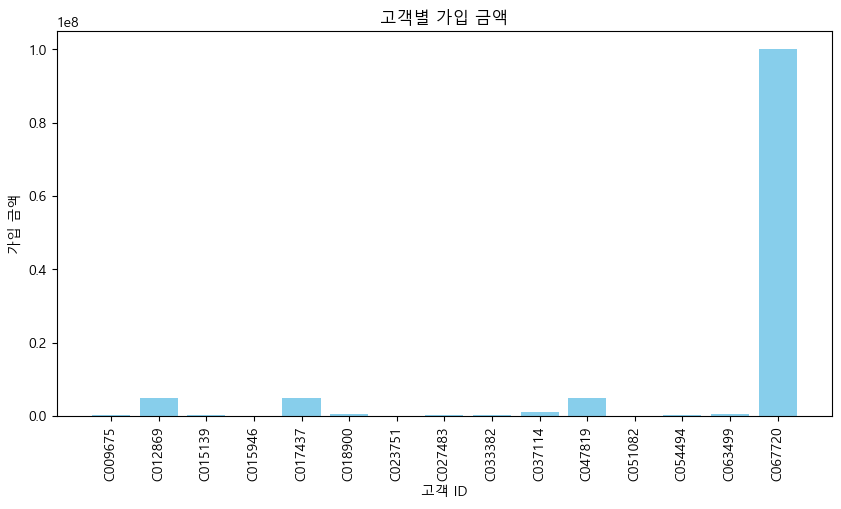

In [13]:
from openpyxl import load_workbook
from openpyxl.drawing.image import Image

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트 설정 (Windows 기준)
plt.rc('font', family='Malgun Gothic')  # Windows
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 폰트 리스트 확인 (Mac/Linux 사용자는 아래 코드 실행 후 한글 폰트 확인)
# for font in fm.findSystemFonts(fontpaths=None, fontext='ttf'):
#     print(font)


# **📌 1. 엑셀 파일로 저장**
excel_filename = "고객_가입금액2.xlsx"
df.to_excel(excel_filename, index=False, sheet_name="고객데이터")

# **📌 2. 데이터 시각화 (차트 생성)**
plt.figure(figsize=(10, 5))
plt.bar(df["고객id"], df["가입금액"], color="skyblue")
plt.xlabel("고객 ID")
plt.ylabel("가입 금액")
plt.title("고객별 가입 금액")
plt.xticks(rotation=90)  # x축 값이 많을 경우 회전

# 차트를 이미지 파일로 저장
chart_filename = "가입금액_차트.png"
plt.savefig(chart_filename, bbox_inches="tight")

# **📌 3. 엑셀 파일에 차트 삽입**
wb = load_workbook(excel_filename)
ws = wb["고객데이터"]

# 이미지 삽입 위치 (예: E2 셀)
img = Image(chart_filename)
ws.add_image(img, "E2")

# 엑셀 저장 후 닫기
wb.save(excel_filename)
wb.close()

print(f"✅ 엑셀 파일 생성 완료: {excel_filename}")

True

Sql Builder 서브그래프


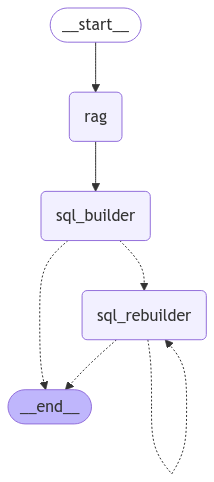


메인 그래프


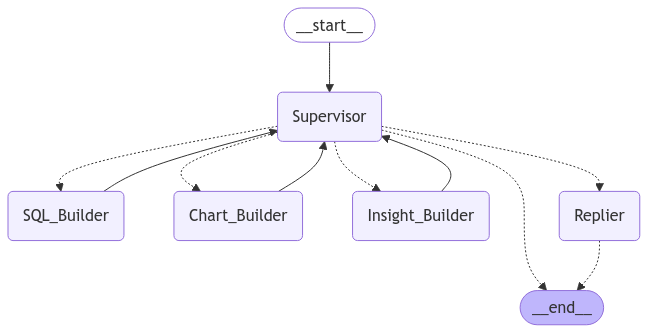

In [23]:
print("Sql Builder 서브그래프")
draw_graph(subgraph_sqlbuilder)

print("\n메인 그래프")
draw_graph(app)

In [24]:
######## 전체 그래프 테스트

### 데이터 조회와 무관한 질문과 응답
print(user_input_common)
ret = app.invoke({"messages":[HumanMessage(content=user_input_common)]})
ret

## c5b55534-a867-454d-bf0b-2985f227e549

안녕


{'messages': [HumanMessage(content='안녕', additional_kwargs={}, response_metadata={}, id='64774b22-1f12-43a3-ae5b-8b64935f5f4e')]}

가입일자가 '2019-12-05'인 고객의 고객ID, 계좌번호, 가입금액을 조회하고 차트로 그려줘
query SELECT 고객id, 계좌번호, 가입금액 
FROM biz.product_history 
WHERE 가입일자 = '2019-12-05';


<string>:27: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
<string>:27: UserWarning: Glyph 44061 (\N{HANGUL SYLLABLE GAEG}) missing from font(s) DejaVu Sans.
<string>:27: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
<string>:27: UserWarning: Glyph 51077 (\N{HANGUL SYLLABLE IB}) missing from font(s) DejaVu Sans.
<string>:27: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from font(s) DejaVu Sans.
<string>:27: UserWarning: Glyph 50529 (\N{HANGUL SYLLABLE AEG}) missing from font(s) DejaVu Sans.
<string>:27: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
<string>:27: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
<string>:27: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
<string>:27: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
<string>:29: UserWar

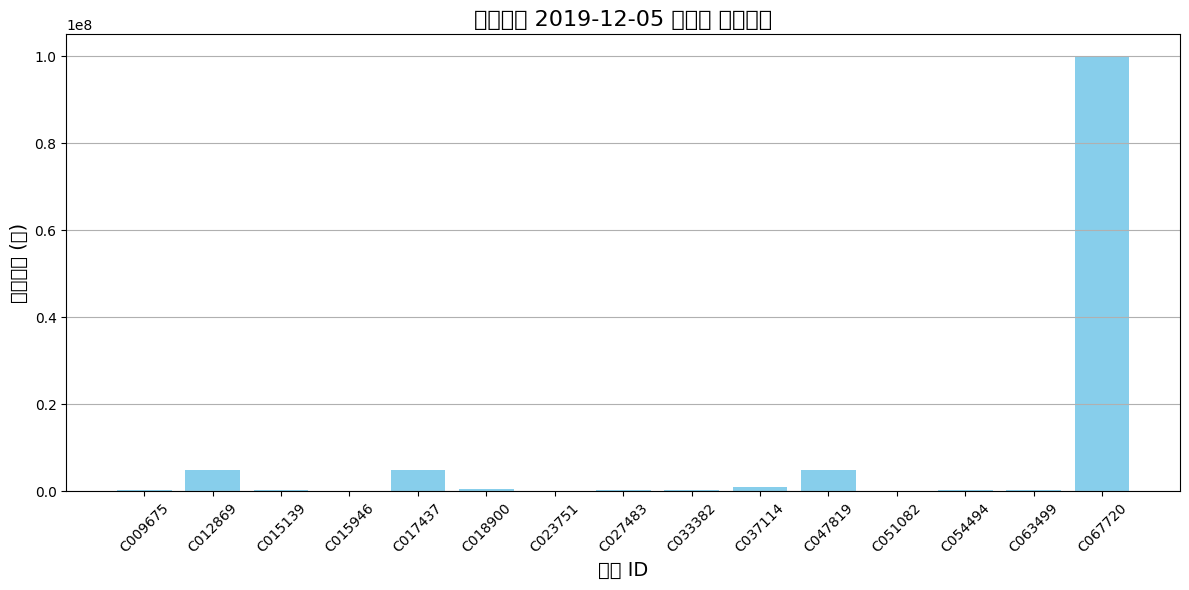

In [12]:

### 데이터 조회 + 차트
print(user_input_querychart)
ret = app.invoke({"messages":[HumanMessage(content=user_input_querychart)]})


In [ ]:

### 데이터 조회 + 인사이트
print(user_input_queryinsight)
ret = app.invoke({"messages":[HumanMessage(content=user_input_queryinsight)]})


In [ ]:

### 데이터 조회 + 차트 + 인사이트
print(user_input_query_chart_insight)
ret = app.invoke({"messages":[HumanMessage(content=user_input_query_chart_insight)]})



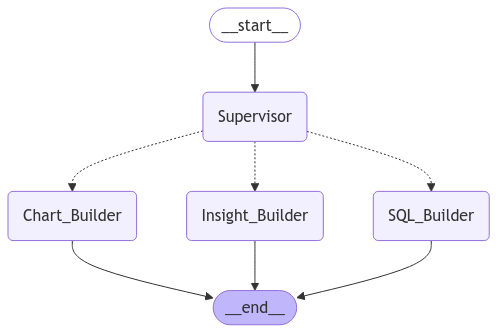

In [22]:
def dummy_supervisor(state: State) -> Command[Literal['SQL_Builder', 'Chart_Builder', 'Insight_Builder']]:
    if state['messages'][-1].content == '차트':
        return Command(goto='Chart_Builder')
    elif state['messages'][-1].content == '인사이트':
        return Command(goto='Insight_Builder')
    else:
        return Command(goto='SQL_Builder')

def dummy_sql_builder(state: State):
    return {}

def dummy_chart_builder(state: State):
    return {}

def dummy_insight_builder(state: State):
    return {}


workflow = StateGraph(MessagesState)
workflow.add_node("Supervisor", dummy_supervisor)
workflow.add_node("SQL_Builder", dummy_sql_builder)
workflow.add_node("Chart_Builder", dummy_chart_builder)
workflow.add_node("Insight_Builder", dummy_insight_builder)

workflow.set_entry_point("Supervisor")
workflow.set_finish_point("SQL_Builder")
workflow.set_finish_point("Chart_Builder")
workflow.set_finish_point("Insight_Builder")

app = workflow.compile()
draw_graph(app)